# Використати різні продемонстровані техніки для очистки даних.


In [2]:
import pandas as pd

diabetes_data = pd.read_csv("../data/diabetes.csv")
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
diabetes_data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
diabetes_data.agg(["min", "max"])


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
min,0,0,0,0,0,0.0,0.078,21,0
max,17,199,122,99,846,67.1,2.420,81,1


In [5]:
# ------ 1 -------
# В першу чергу думаю варто передивитись наявні типи відповідно до фактичних (і потенційно можливих) значень.
# Більшість цілочислених колонок мають тільки додатні значення і лягають в діапазон 0-255, тож підуть у unit8.
# Glucose, Insulin - можуть мітити (або містять) очікувані значення більші за 255, проте все ще не потребують відʼємних значень, залсужено йдуть в uint16.
# флоати просто трохи урізаємо з стандарного 64 до 32.
# Outcome виділяємо як категорію.
diabetes_data = pd.read_csv("../data/diabetes.csv", dtype={
        "Pregnancies": "uint8",
        "Glucose": "uint16",
        "BloodPressure": "uint8",
        "SkinThickness": "uint8",
        "Insulin": "uint16",
        "BMI": "float32",
        "DiabetesPedigreeFunction": "float32",
        "Age": "uint8",
        "Outcome": "category",
    },)
diabetes_data.info()

# Як результат маємо зменшення з 54.1КБ до 13КБ, виглядає досить непогано.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    uint8   
 1   Glucose                   768 non-null    uint16  
 2   BloodPressure             768 non-null    uint8   
 3   SkinThickness             768 non-null    uint8   
 4   Insulin                   768 non-null    uint16  
 5   BMI                       768 non-null    float32 
 6   DiabetesPedigreeFunction  768 non-null    float32 
 7   Age                       768 non-null    uint8   
 8   Outcome                   768 non-null    category
dtypes: category(1), float32(2), uint16(2), uint8(4)
memory usage: 13.0 KB


In [6]:
# Про всяк випадок додаю Id, щоб легше було відстежити записи після змін
import numpy as np
diabetes_data.insert(0, "row_id", np.arange(len(diabetes_data), dtype="int64"))

In [7]:
# ------ 2 ------
# Далі перейдемо до нулів, для початку подивимось чи є вони у нас і де вони можуть бути проблемою.
diabetes_data[(diabetes_data == 0).any(axis=1) | diabetes_data.isna().any(axis=1)]

,row_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.599998,0.627,50,1
1,1,1,85,66,29,0,26.600000,0.351,31,0
2,2,8,183,64,0,0,23.299999,0.672,32,1
4,4,0,137,40,35,168,43.099998,2.288,33,1
5,5,5,116,74,0,0,25.600000,0.201,30,0
...,...,...,...,...,...,...,...,...,...,...
761,761,9,170,74,31,0,44.000000,0.403,43,1
762,762,9,89,62,0,0,22.500000,0.142,33,0
764,764,2,122,70,27,0,36.799999,0.340,27,0
766,766,1,126,60,0,0,30.100000,0.349,47,1


In [8]:
(diabetes_data == 0).groupby(diabetes_data["Outcome"], observed=True).sum()

# В мене була теорія що можливо дані заповнені не рівномірно по категоріях. Типу значення інсуліну пропущено для НЕ діабетиків.
# Але вона не справдилась тож будемо працювати з усім разом.

,row_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Outcome,,,,,,,,,,
0,0,73,3,19,139,236,9,0,0,0
1,1,38,2,16,88,138,2,0,0,0


In [9]:
# null та NaN не маємо, що вже добре. Тож зосередимось на 0.
# Для вагітностей - це окей. По Glucose і BMI є пару по пару пропусків, а от SkinThickness і Insulin (як не дивно, в таблиці по діабету) мають багато пропущених записів.

# Мені здається що генерувати штучно 15-20% записів це якось занадто, тож заповню лише ті колонки які мають невелику кількість пропусків
cols_with_missing = [
    "Glucose",
    "BloodPressure",
    "BMI"
]

diabetes_data_non_nulled = diabetes_data.copy(deep=True)


# Медіана в межах категорії виглядає досить адекватно.
diabetes_data_non_nulled[cols_with_missing] = (
    diabetes_data_non_nulled
    .groupby("Outcome", observed=True)[cols_with_missing]
    .transform(lambda s: s.mask(s == 0, s.mask(s == 0).median()))
)

(diabetes_data_non_nulled[cols_with_missing] == 0).sum().sort_values(ascending=False)

Glucose          0
BloodPressure    0
BMI              0
dtype: int64

In [10]:
# before
diabetes_data[diabetes_data["row_id"].isin([7, 9, 75])]

,row_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,7,10,115,0,0,0,35.299999,0.134,29,0
9,9,8,125,96,0,0,0.000000,0.232,54,1
75,75,1,0,48,20,0,24.700001,0.140,22,0


In [11]:
# after
diabetes_data_non_nulled[diabetes_data_non_nulled["row_id"].isin([7, 9, 75])]

,row_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,7,10,115,70.0,0,0,35.299999,0.134,29,0
9,9,8,125,96.0,0,0,34.299999,0.232,54,1
75,75,1,107,48.0,20,0,24.700001,0.140,22,0


In [12]:
# ------ 3 ------
# Тепер розглянемо інші викиди
# Для початку їх треба знайти

def iqr_outliers(df, cols, k=1.5):
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr

    outliers = ((df[cols] < lower) | (df[cols] > upper))
    return outliers, outliers.sum(), lower, upper


num_cols = diabetes_data_non_nulled.select_dtypes(include="number").columns.drop(["row_id"], errors="ignore")

outlier_mask, outlier_counts, lower, upper = iqr_outliers(
    diabetes_data_non_nulled,
    cols_with_missing
)

outlier_counts.sort_values(ascending=False)

BloodPressure    14
BMI               8
Glucose           0
dtype: int64

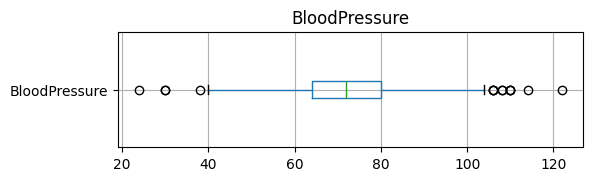

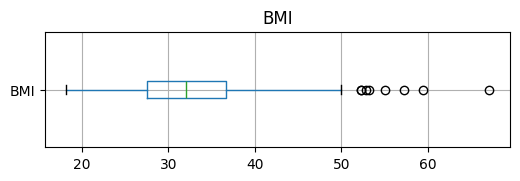

In [13]:
# Хочеться власними очима глянуть на ті викиди
import matplotlib.pyplot as plt

cols_with_outliers = outlier_counts[outlier_counts > 0].index

for c in cols_with_outliers:
    plt.figure(figsize=(6, 1.5))
    diabetes_data_non_nulled[[c]].boxplot(vert=False)
    plt.title(c)
    plt.show()


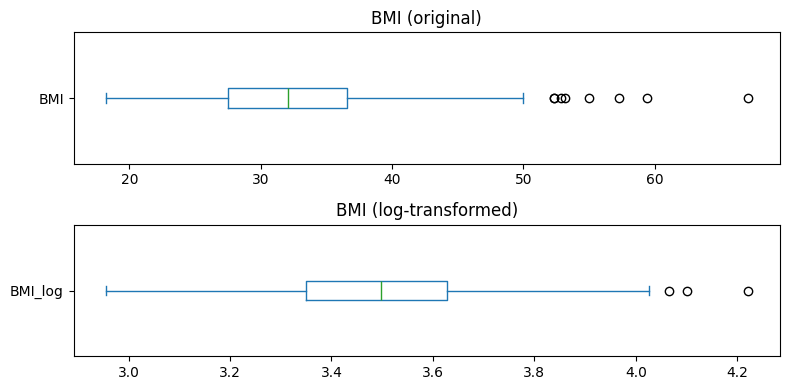

In [14]:
# Виглядають ці викиди досить прийнятно, тому обрізати їх не бачу сенсу. Натомість трансформуємо.
# Наскільки я зрозумів цей підхід більш корисний якщо в подальшому дані будуть викоритовувати моделі.

diabetes_data_non_nulled["BMI_log"] = np.log1p(diabetes_data_non_nulled["BMI"])

fig, axes = plt.subplots(2, 1, figsize=(8, 4))

diabetes_data_non_nulled["BMI"].plot(
    kind="box", vert=False, ax=axes[0], title="BMI (original)"
)

diabetes_data_non_nulled["BMI_log"].plot(
    kind="box", vert=False, ax=axes[1], title="BMI (log-transformed)"
)

plt.tight_layout()
plt.show()

# Викидів ми не прям позбулися, певні екстримальні значення все ще лишись, але хвіст однозначно менш розтягнутий.

In [15]:
# ------ 4 ------
# Враховуючи що BloodPressure обмежений людською природою, то я думаю тут буде доречно зробити sanity checks.
# Оскільки людина (жива і неушкоджена) не може мати тиск більше та менше певного значення,
# то ми не можумо розлядати екстримальні значення як викиди, а радше мусимо розлядати як некоретно введення даних.
# Вже використовував перезапис значень і трансформацію, тож на цей раз підемо шляхом додаткового поля-прапору.


diabetes_data_non_nulled["BloodPressure_invalid"] = (
    (diabetes_data_non_nulled["BloodPressure"] < 40) | (diabetes_data_non_nulled["BloodPressure"] > 200)
).astype("boolean")
# Потенційно може бути категорією, але не певен чи є сенс якщо там тру-фолс,
# а розділяти на лов-норм-хай теж наразі не бачу сенсу.

diabetes_data_non_nulled[diabetes_data_non_nulled["BloodPressure_invalid"] == True]

,row_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_log,BloodPressure_invalid
18,18,1,103,30.0,38,83,43.299999,0.183,33,0,3.790985,True
125,125,1,88,30.0,42,99,55.000000,0.496,26,1,4.025352,True
597,597,1,89,24.0,19,25,27.799999,0.559,21,0,3.360375,True
599,599,1,109,38.0,18,120,23.100000,0.407,26,0,3.182212,True


In [19]:
diabetes_data_non_nulled.to_csv("../data/diabetes_non_nulled.csv", index=False)